In [1]:
import os
import pickle

import librosa
import math

import hmmlearn.hmm as hmm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from preprocessing import get_mfcc

from utils import  get_all_words

import seaborn as sns
import matplotlib.pyplot as plt

# 1. Params

In [2]:
class_names = get_all_words()
states = np.ones(len(class_names), dtype=int) * 3
n_mix = 2

In [3]:
dataset_path = 'datasets_split'

model_path = 'models_train'

In [4]:
def load_data(dataset_path: str, class_names: str):
    length = 0
    for cn in class_names:
        length += len(os.listdir(f"{dataset_path}/{cn}"))
    print('Total samples:', length)

    X = {'train': {}, 'test': {}}
    y = {'train': {}, 'test': {}}

    all_data = {}
    all_labels = {}
    for cname in class_names:
        file_paths = [os.path.join(dataset_path, cname, i) for i in os.listdir(
            os.path.join(dataset_path, cname)) if i.endswith('.wav')]
        data = [get_mfcc(file_path) for file_path in file_paths]
        all_data[cname] = data
        all_labels[cname] = [class_names.index(cname) for _ in range(len(file_paths))]

    for cname in class_names:
        x_train, x_test, y_train, y_test = train_test_split(
            all_data[cname], all_labels[cname],
            test_size=0.33,
            random_state=42
        )

        X['train'][cname] = x_train
        X['test'][cname] = x_test
        y['test'][cname] = y_test

    total_train = 0
    total_test = 0
    for cname in class_names:
        train_count = len(X['train'][cname])
        test_count = len(X['test'][cname])
        print(cname, 'train:', train_count, '| test:', test_count)
        total_train += train_count
        total_test += test_count
    print('train samples:', total_train)
    print('test samples', total_test)

    return X, y

In [5]:
X, y = load_data(dataset_path, class_names)

Total samples: 520
chu train: 6 | test: 4
ve train: 6 | test: 4
vao train: 6 | test: 4
tai train: 6 | test: 4
dau train: 6 | test: 4
cuoi train: 6 | test: 4
ke train: 6 | test: 4
truoc train: 6 | test: 4
dung train: 6 | test: 4
ngung train: 6 | test: 4
doc train: 6 | test: 4
tiep train: 6 | test: 4
lui train: 6 | test: 4
toi train: 6 | test: 4
tang train: 6 | test: 4
to train: 6 | test: 4
giam train: 6 | test: 4
nho train: 6 | test: 4
lai train: 6 | test: 4
lap train: 6 | test: 4
nhanh train: 6 | test: 4
cham train: 6 | test: 4
luu train: 6 | test: 4
xoa train: 6 | test: 4
huy train: 6 | test: 4
chay train: 6 | test: 4
xong train: 6 | test: 4
ddung train: 6 | test: 4
sai train: 6 | test: 4
giup train: 6 | test: 4
gio train: 6 | test: 4
ngay train: 6 | test: 4
tuoi train: 6 | test: 4
co train: 6 | test: 4
khong train: 6 | test: 4
muc train: 6 | test: 4
bai train: 6 | test: 4
mot train: 6 | test: 4
hai train: 6 | test: 4
ba train: 6 | test: 4
bon train: 6 | test: 4
nam train: 6 | test: 4

In [6]:
def show_train_test_data(X: dict[str, dict]):
    cothe_train_len = X['train']['cothe'].__len__()
    khong_train_len = X['train']['khong'].__len__()
    nhung_train_len = X['train']['nhung'].__len__()

    cothe_test_len = X['test']['cothe'].__len__()
    khong_test_len = X['test']['khong'].__len__()
    nhung_test_len = X['test']['nhung'].__len__()

    # Tạo dữ liệu từ các giá trị độ dài đã cho
    data = {
        "Category": ["cothe", "cothe", "khong", "khong", "nhung", "nhung"],
        "Dataset": ["Train", "Test", "Train", "Test", "Train", "Test"],
        "Samples": [cothe_train_len, cothe_test_len, khong_train_len, khong_test_len, nhung_train_len, nhung_test_len]
    }

    df = pd.DataFrame(data)

    # Plotting
    plt.figure(figsize=(8, 6))
    sns.barplot(data=df, x="Category", y="Samples", hue="Dataset", palette="viridis")
    plt.title("Training and Testing Sample Distribution", fontsize=16)
    plt.xlabel("Category", fontsize=14)
    plt.ylabel("Number of Samples", fontsize=14)
    plt.legend(title="Dataset", fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

In [7]:
# show_train_test_data(X)

# 2.Training

In [8]:
def train(X: dict[str, dict], class_names: list[str], states: list[int], n_mix: int = 2):
    models = {}
    likelihoods = {}

    for idx, cname in enumerate(class_names):
        start_prob = np.full(states[idx], 0.0)
        start_prob[0] = 1.0
        trans_matrix = np.full((states[idx], states[idx]), 0.0)
        p = 0.5
        np.fill_diagonal(trans_matrix, p)
        np.fill_diagonal(trans_matrix[0:, 1:], 1 - p)
        trans_matrix[-1, -1] = 1.0
        trans_matrix = trans_matrix / (states[idx] - 2)

        # trans matrix
        print(cname)
        print(trans_matrix)
        
        models[cname] = hmm.GMMHMM(
            n_components=states[idx],
            n_mix=n_mix,
            verbose=False,
            n_iter=300,
            startprob_prior=start_prob,
            transmat_prior=trans_matrix,
            params='stmc',
            init_params='mc',
            random_state=42
        )

        models[cname].fit(X=np.vstack(X['train'][cname]),
                                lengths=[x.shape[0] for x in X['train'][cname]])

        likelihoods[cname] = models[cname].monitor_.history

    return models, likelihoods

In [9]:
models, likelihoods = train(X, class_names, states, n_mix)

chu
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]
ve
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]
vao
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]
tai
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]
dau
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]
cuoi
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]
ke
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]
truoc
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]
dung
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]
ngung
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]
doc
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]
tiep
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]
lui
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]
toi
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]
tang
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]
to
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]
giam
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]
nho
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]
lai
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]
lap
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  

Model is not converging.  Current: -90301.28730000669 is not greater than -90297.70277210847. Delta is -3.584527898216038


co
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]
khong
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]
muc
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]
bai
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]
mot
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]
hai
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]
ba
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]
bon
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]
nam
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]
sau
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]
bay
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]
tam
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]
chin
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]
a
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]
e
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]
i
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]
o
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]
u
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]
thodia
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


In [10]:
def calculate_delta(likelihood: list[float]):
    delta = []
    for i in range(1, len(likelihood)):
        delta.append(likelihood[i] - likelihood[i - 1])
    return delta

In [11]:
def plot_likelihoods(likelihoods: dict[str, list[float]]):
    plt.figure(figsize=(10, 10))
    
    ind = 1
    sum_row = class_names.__len__()

    for cname in class_names:
        plt.subplot(sum_row, 2, ind)
        ind += 1
        plt.plot(calculate_delta(likelihoods[cname]), label=cname, color='red')
        plt.title('Log-Likelihood Change: ' + cname)
        plt.xlabel('Iteration')
        plt.ylabel('Change in negative log likelihood')
        plt.legend()

        plt.subplot(sum_row, 2, ind)
        ind += 1
        plt.plot(likelihoods[cname], label=cname, color='blue')
        plt.title('Log likelihood of training data: ' + cname)
        plt.xlabel('Iteration')
        plt.ylabel('Negative log likelihood')
        plt.legend()

        # gap between subplots
        plt.tight_layout()
        
    plt.show()

In [12]:
# plot_likelihoods(likelihoods)

In [13]:
def show_prob(models: dict[str, hmm.GMMHMM], class_names: list[str]):
    for cname in class_names:
        print("\nMa trận chuyển tiếp trạng thái ẩn của \"" + cname +"\":")
        print(models[cname].transmat_)

show_prob(models, class_names)


Ma trận chuyển tiếp trạng thái ẩn của "chu":
[[0.99257652 0.00742348 0.        ]
 [0.         0.95671398 0.04328602]
 [0.03423584 0.         0.96576416]]

Ma trận chuyển tiếp trạng thái ẩn của "ve":
[[0.93171486 0.03549894 0.0327862 ]
 [0.03503102 0.96496898 0.        ]
 [0.00627261 0.         0.99372739]]

Ma trận chuyển tiếp trạng thái ẩn của "vao":
[[0.99273769 0.00726231 0.        ]
 [0.03204725 0.93288769 0.03506506]
 [0.         0.02549283 0.97450717]]

Ma trận chuyển tiếp trạng thái ẩn của "tai":
[[0.99273084 0.00726916 0.        ]
 [0.         0.96994171 0.03005829]
 [0.03720195 0.         0.96279805]]

Ma trận chuyển tiếp trạng thái ẩn của "dau":
[[0.99370206 0.         0.00629794]
 [0.03251101 0.96748899 0.        ]
 [0.         0.03061925 0.96938075]]

Ma trận chuyển tiếp trạng thái ẩn của "cuoi":
[[0.9902109  0.         0.0097891 ]
 [0.         0.96045402 0.03954598]
 [0.05958935 0.03720682 0.90320384]]

Ma trận chuyển tiếp trạng thái ẩn của "ke":
[[0.99305891 0.00694109 0

# Fix

In [14]:
def probability_distribution_of_points(models: dict[str, hmm.GMMHMM], class_names: list):
    inx = 1
    
    plt.figure(figsize=(12, 4))
    for cname in class_names:
        result = models[cname].score_samples(np.vstack(X['train'][cname]))
        arr = result[1]

        x, y = arr[:, 0], arr[:, 1]
        plt.subplot(1, 3, inx)
        inx += 1
        plt.scatter(x, y, alpha=0.6, edgecolors='k')
        plt.title("Prob Distribution of points: " + cname, fontsize=14)
        plt.xlabel("State 1", fontsize=12)
        plt.ylabel("State 2", fontsize=12)
        plt.grid(True)
        plt.tight_layout()
    plt.show()

In [15]:
# probability_distribution_of_points(models, class_names)

# Evaluation

In [16]:
def evaluation(model: dict, X: dict[str, dict], y: dict[str, dict], class_names: list[str]):
    import numpy as np
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt

    y_true = []
    y_pred = []
    
    # Duyệt qua từng lớp
    for cname in class_names:
        true_for_class = []
        pred_for_class = []
        
        # Duyệt qua từng mẫu của lớp
        for mfcc, target in zip(X['test'][cname], y['test'][cname]):
            try:
                # Tính điểm số
                scores = [model[c].score(mfcc) for c in class_names]
                pred = np.argmax(scores)
                
                # Lưu kết quả
                true_for_class.append(target)
                pred_for_class.append(pred)
            except Exception as e:
                print(f"Error processing sample for class {cname}: {e}")

        # Cập nhật danh sách chung
        y_true.extend(true_for_class)
        y_pred.extend(pred_for_class)
        
        # Accuracy cho từng lớp
        if len(true_for_class) > 0:
            acc = np.sum(np.array(true_for_class) == np.array(pred_for_class)) / len(true_for_class)
            print(f'{cname}: {acc:.2f}')
        else:
            print(f'{cname}: No data to evaluate.')

    # Ma trận nhầm lẫn
    print('======')
    print('Confusion matrix:')
    cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))
    print(cm)

    # Accuracy tổng thể
    overall_acc = np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true) if len(y_true) > 0 else 0
    print('Accuracy:', overall_acc)

    # Vẽ ma trận nhầm lẫn
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, xticklabels=class_names, yticklabels=class_names, annot=True, fmt='d', cmap="Blues")
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

chu: 1.00
ve: 1.00
vao: 1.00
tai: 0.50
dau: 1.00
cuoi: 1.00
ke: 1.00
truoc: 1.00
dung: 1.00
ngung: 1.00
doc: 1.00
tiep: 0.50
lui: 0.75
toi: 1.00
tang: 1.00
to: 1.00
giam: 1.00
nho: 1.00
lai: 0.50
lap: 1.00
nhanh: 1.00
cham: 1.00
luu: 1.00
xoa: 1.00
huy: 1.00
chay: 0.75
xong: 0.50
ddung: 1.00
sai: 0.50
giup: 1.00
gio: 1.00
ngay: 1.00
tuoi: 1.00
co: 0.75
khong: 1.00
muc: 0.75
bai: 1.00
mot: 0.50
hai: 1.00
ba: 0.50
bon: 1.00
nam: 1.00
sau: 1.00
bay: 1.00
tam: 0.75
chin: 1.00
a: 0.50
e: 0.75
i: 1.00
o: 0.25
u: 1.00
thodia: 1.00
Confusion matrix:
[[4 0 0 ... 0 0 0]
 [0 4 0 ... 0 0 0]
 [0 0 4 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 4 0]
 [0 0 0 ... 0 0 4]]
Accuracy: 0.8798076923076923


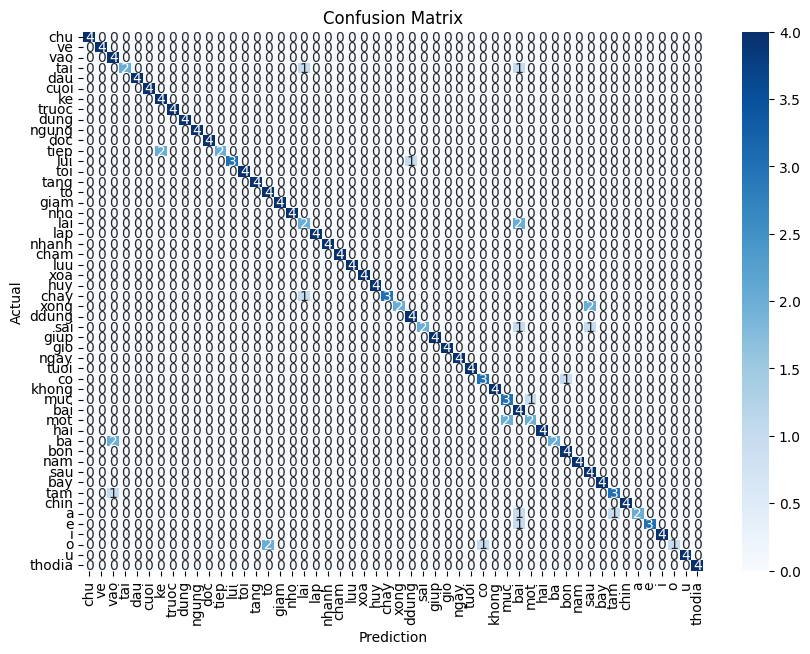

In [17]:
evaluation(models, X, y, class_names)

In [18]:
def save_model(models: dict, class_names, model_path: str, model_key: str):
    print(f'Saving models to {model_path}/{model_key}')
    for cname in class_names:
        name = f'{model_path}/{model_key}/model_{cname}.pkl'
        if not os.path.exists(f'{model_path}/{model_key}'):
            os.makedirs(f'{model_path}/{model_key}')
        with open(name, 'wb') as file:
            pickle.dump(models[cname], file)

In [19]:
save_model(models, class_names, model_path, f"second")

Saving models to models_train/second
